## Import Packages

In [1]:
# Import Python packages
import pandas as pd
import plotly.express as px
import plotly.io as pio
import json
import sys
import cachetools

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window

## Connect to Snowflake

In [3]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "accountadmin",
    "warehouse": "tasty_dsci_wh",
    "database": "frostbyte_tasty_bytes_dev",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

## Snowpark DataFrame


In [4]:
snowpark_df = session.table("frostbyte_tasty_bytes_dev.analytics.shift_sales_v")

## Preview the Data

In [5]:
snowpark_df.show()

-------------------------------------------------------------------------------------------------------------------------------------------------
|"LOCATION_ID"  |"CITY"         |"DATE"      |"SHIFT_SALES"  |"SHIFT"  |"MONTH"  |"DAY_OF_WEEK"  |"CITY_POPULATION"  |"LATITUDE"  |"LONGITUDE"  |
-------------------------------------------------------------------------------------------------------------------------------------------------
|2574           |New York City  |2023-05-02  |NULL           |AM       |5        |2              |8804190            |40.731148   |-74.003081   |
|2574           |New York City  |2023-05-05  |NULL           |AM       |5        |5              |8804190            |40.731148   |-74.003081   |
|2574           |New York City  |2023-05-01  |NULL           |AM       |5        |1              |8804190            |40.731148   |-74.003081   |
|2574           |New York City  |2023-05-07  |NULL           |AM       |5        |0              |8804190            |40.731

## Select, Filter, Sort

In [6]:
# Select
location_df = snowpark_df.select("date", "shift", "shift_sales", "location_id", "city")

# Filter
location_df = location_df.filter(F.col("location_id") == 1135)

# Sort
location_df = location_df.order_by(["date", "shift"], ascending=[0, 0])

# Display
location_df.show(n=20)

--------------------------------------------------------------------
|"DATE"      |"SHIFT"  |"SHIFT_SALES"  |"LOCATION_ID"  |"CITY"     |
--------------------------------------------------------------------
|2023-05-07  |PM       |NULL           |1135           |Vancouver  |
|2023-05-07  |AM       |NULL           |1135           |Vancouver  |
|2023-05-06  |PM       |NULL           |1135           |Vancouver  |
|2023-05-06  |AM       |NULL           |1135           |Vancouver  |
|2023-05-05  |PM       |NULL           |1135           |Vancouver  |
|2023-05-05  |AM       |NULL           |1135           |Vancouver  |
|2023-05-04  |PM       |NULL           |1135           |Vancouver  |
|2023-05-04  |AM       |NULL           |1135           |Vancouver  |
|2023-05-03  |PM       |NULL           |1135           |Vancouver  |
|2023-05-03  |AM       |NULL           |1135           |Vancouver  |
|2023-05-02  |PM       |NULL           |1135           |Vancouver  |
|2023-05-02  |AM       |NULL      

## How many rows are in our data?

In [9]:
snowpark_df.count()

1938202

## Let's calculate some descriptive statistics.

In [10]:
snowpark_df.describe().to_pandas()

,SUMMARY,LOCATION_ID,CITY,SHIFT_SALES,SHIFT,MONTH,DAY_OF_WEEK,CITY_POPULATION,LATITUDE,LONGITUDE
0,min,1.001000e+03,Barcelona,7.600000e-01,AM,1.000000e+00,0.000000e+00,1.056610e+05,-3.832745e+01,-1.232431e+02
1,max,1.551700e+04,Warsaw,4.785360e+03,PM,1.200000e+01,6.000000e+00,1.634983e+07,5.948668e+01,1.513234e+02
2,stddev,4.234979e+03,None,4.381358e+02,None,3.223800e+00,1.996656e+00,4.566943e+06,2.839821e+01,7.830981e+01
3,count,1.938202e+06,1938202,1.755096e+06,1938202,1.938202e+06,1.938202e+06,1.938202e+06,1.938202e+06,1.938202e+06
4,mean,8.119924e+03,None,6.092432e+02,None,6.169526e+00,3.000784e+00,4.325339e+06,3.168076e+01,-3.415415e+00


## What are the numeric columns?

In [11]:
# Define Snowflake numeric types
numeric_types = [T.DecimalType, T.DoubleType, T.FloatType, T.IntegerType, T.LongType]

# Get numeric columns
numeric_columns = [col.name for col in snowpark_df.schema.fields if type(col.datatype) in numeric_types]
numeric_columns

['LOCATION_ID',
 'SHIFT_SALES',
 'MONTH',
 'DAY_OF_WEEK',
 'CITY_POPULATION',
 'LATITUDE',
 'LONGITUDE']

## What are the categorical columns?

In [12]:
# Define Snowflake categorical types
categorical_types = [T.StringType]

# Get categorical columns
categorical_columns = [col.name for col in snowpark_df.schema.fields if type(col.datatype) in categorical_types]
categorical_columns

['CITY', 'SHIFT']

## What are the average shift sales (USD) by city?

<Axes: ylabel='CITY'>

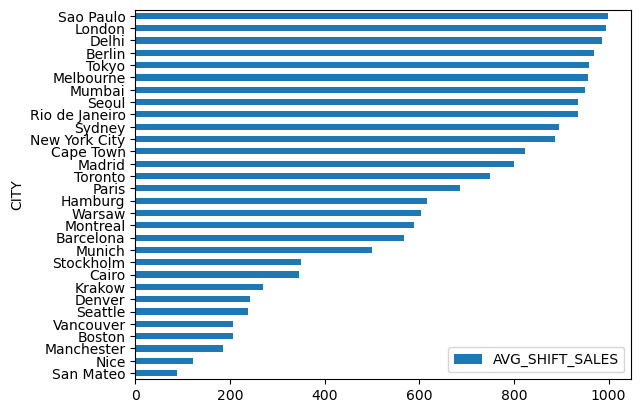

In [13]:
# Group by city and average shift sales
analysis_df = snowpark_df.group_by("city").agg(F.mean("shift_sales").alias("avg_shift_sales"))

# Sort by average shift sales
analysis_df = analysis_df.sort("avg_shift_sales", ascending=True)

# Pull to pandas and plot
analysis_df.to_pandas().plot.barh(x="CITY", y="AVG_SHIFT_SALES")

## Test city: Vancouver, how many locations are there?

In [14]:
# Filter to Vancouver
analysis_df = snowpark_df.filter(F.col("city") == "Vancouver")

# Group by location and average shift sales
analysis_df = analysis_df.group_by("location_id").agg(F.mean("shift_sales").alias("avg_shift_sales"))

# Get the location count
print("Vancouver location count:", analysis_df.count())

Vancouver location count: 435


## What is the distribution of average shift sales (USD) by location in Vancouver?

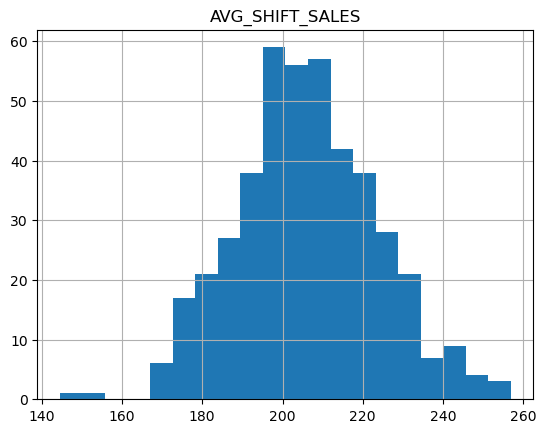

In [15]:
ax = analysis_df.to_pandas().hist(column="AVG_SHIFT_SALES", bins=20)


**All transformations for feature engineering in this notebook will be executed on Snowflake compute.**


## Create a Rolling Average Feature
We will use a Snowflake window function to get a **rolling shift average by location** over time. Window functions allow us to aggregate on a "moving" group of rows.

**Step 1. Create a Window**

Our window will partition the data by location and shift. It will order rows by date. It will include all rows prior to the current date of the observation it is aggregating for.

In [16]:
window_by_location_all_days = (
    Window.partition_by("location_id", "shift")
    .order_by("date")
    .rows_between(Window.UNBOUNDED_PRECEDING, Window.CURRENT_ROW - 1)
)

**Step 2. Aggregate across the Window**

In [17]:
snowpark_df = snowpark_df.with_column(
    "avg_location_shift_sales", 
    F.avg("shift_sales").over(window_by_location_all_days)
)

## Impute Missing Values
The rolling average feature we just created is missing if there are no prior shift sales at that location. We will replace those missing values with 0.

In [18]:
snowpark_df = snowpark_df.fillna(value=0, subset=["avg_location_shift_sales"])

## Encode Categorical Columns
Categorical columns need to be represented as numeric in our model. We will use binary encoding for the **shift** column by replacing:
- "AM" with 1
- "PM" with 0

In [19]:
snowpark_df = snowpark_df.with_column("shift", F.iff(F.col("shift") == "AM", 1, 0))

## Filter to Historical Data
Our data includes placeholders for future data with missing shift sales. The **future data** represents the next 7 days of shifts for all locations. The **historical data** has shift sales for all locations where a food truck parked during a shift. We will only use historical data when training our model and will filter out the dates where the **shift_sales** column is missing.

In [20]:
historical_snowpark_df = snowpark_df.filter(F.col("shift_sales").is_not_null())

## Drop Columns
Drop ID columns that will not be used in the model.

In [21]:
historical_snowpark_df = historical_snowpark_df.drop("location_id", "city", "date")

## Split Data into Training and Testing
We will use 80% of the data for model training and 20% for testing.<br>

In [22]:
train_snowpark_df, test_snowpark_df = historical_snowpark_df.randomSplit([0.8, 0.2])

## Save Tables in Snowflake
We will save our training and test datasets to the **analytics schema** in our Snowflake account.<br>

In [23]:
# Save training data
train_snowpark_df.write.mode("overwrite").save_as_table("frostbyte_tasty_bytes_dev.analytics.shift_sales_train")

# Save test data
test_snowpark_df.write.mode("overwrite").save_as_table("frostbyte_tasty_bytes_dev.analytics.shift_sales_test")

## Training the model in Snowflake!

## Create a Stage
We will use this stage to host user-defined functions, stored procedures, and model files on Snowflake.

In [24]:
# Create stage
session.sql("CREATE STAGE IF NOT EXISTS model_stage").collect()

[Row(status='Stage area MODEL_STAGE successfully created.')]

## Create a Stored Procedure for Model Training

**Step 1. Create a Function for Training a Model**<br>
This function trains a Scikit-learn linear regression model and saves the model to a stage. Linear regression finds a line that best fits the data points used in training. We then use that line as an estimation of where output values will be for future scenarios.

Here, training will use historical shift sales and features in our data to predict future shift sales of locations where our food trucks can park.
- **Inputs:** Training table name on Snowflake, feature column names, target column names, file name for the saved model
- **Outputs:**  Feature weights of the trained model *(or feature contributions to the predicted value)*

In [25]:
def train_linreg(
    session: Session,
    training_table: str,
    feature_cols: list,
    target_col: str,
    model_name: str,
) -> T.Variant:

    # Import packages
    from sklearn.linear_model import LinearRegression
    from joblib import dump

    # Get training data
    df = session.table(training_table).to_pandas()

    # Set inputs X and outputs y
    X = df[feature_cols]
    y = df[target_col]

    # Train model
    model = LinearRegression().fit(X, y)

    # Get feature weights
    feature_weights = pd.DataFrame({"Feature": model.feature_names_in_, "Weight": model.coef_}).to_dict()

    # Save model
    dump(model, "/tmp/" + model_name)
    session.file.put(
        "/tmp/" + model_name,
        "@MODEL_STAGE",
        auto_compress=False,
        overwrite=True
    )

    # Return feature contributions
    return feature_weights


**Step 2. Register the Function on Snowflake**<br>
To register the function on Snowflake as a stored procedure, specify what Python packages are required in the function. Here we specify:
- Snowpark
- Scikit-learn (for training our model)
- Joblib (for creating a model file)

In [26]:
train_linreg_snowflake = session.sproc.register(
    func=train_linreg,
    name="sproc_train_linreg",
    is_permanent=True,
    replace=True,
    stage_location="@MODEL_STAGE",
    packages=["snowflake-snowpark-python", "scikit-learn", "joblib"]
)


## Model Training
We will now train our model on Snowflake using our stored procedure. If more memory was required, a Snowpark Optimized Warehouse could be used. In this case, a standard Snowflake warehouse is sufficient.


**Call the Training Stored Procedure** <br>
We will call our stored procedure and specify our training table location, feature and target columns, and our saved model name. This will perform model training in Snowflake.<br>

In [27]:
# Specify inputs
training_table = "frostbyte_tasty_bytes_dev.analytics.shift_sales_train"
model_name = "linreg_location_sales_model.sav"
feature_cols = [
    "MONTH",
    "DAY_OF_WEEK",
    "LATITUDE",
    "LONGITUDE",
    "CITY_POPULATION",
    "AVG_LOCATION_SHIFT_SALES",
    "SHIFT",
]
target_col = "SHIFT_SALES"


# Call the training stored procedure
feature_contributions = train_linreg_snowflake(
    session, training_table, feature_cols, target_col, model_name
)

## Examine Feature Contributions
Our stored procedure returns the feature contributions. Here we can see which features have the largest impact on shift sales predictions. The prediction provided by the linear regression model is a summation of the feature values multiplied by their respective weights (plus an additional bias term). We can see that people are hungrier in the afternoon!<br>
**Value**: Training in a stored procedure isn't a black-box process. We can return the insight we need (in this case, the feature weights) or write to a table in Snowflake.

In [28]:
pd.DataFrame(eval(feature_contributions)).sort_values(by="Weight")

,Feature,Weight
6,SHIFT,-12.573654
0,MONTH,-7.820030
2,LATITUDE,-0.239778
4,CITY_POPULATION,0.000005
3,LONGITUDE,0.081510
5,AVG_LOCATION_SHIFT_SALES,1.097056
1,DAY_OF_WEEK,2.719052


## View the Saved Model
Let's make sure our model is saved to the stage on Snowflake. We will list the files on the stage and see when they were last modified.

In [29]:
pd.DataFrame(session.sql("LIST @MODEL_STAGE").collect())

,name,size,md5,last_modified
0,model_stage/linreg_location_sales_model.sav,1072,207661d1ec506c9986d51ef3496e766f,"Sat, 25 May 2024 18:22:35 GMT"


## Create a User-Defined Function for Model Inference


In [31]:
# Function to load the model from file and cache the result
@cachetools.cached(cache={})
def load_model(filename):
    
    # Import packages
    import sys
    import os
    import joblib
    
    # Get the import directory where the model file is stored
    import_dir = sys._xoptions.get("snowflake_import_directory")
    
    # Get the import directory where the model file is stored
    if import_dir:
        with open(os.path.join(import_dir, filename), 'rb') as file:
            m = joblib.load(file)
            return m

# Function to predict shift sales
def linreg_predict_location_sales(X: pd.DataFrame) -> pd.Series:
    
    # Load the model
    model = load_model("linreg_location_sales_model.sav")

    # Get predictions
    predictions = model.predict(X)

    # Return rounded predictions
    return predictions.round(2)

**Step 2. Register the Function on Snowflake**<br>
To register the function on Snowflake as a user-defined function, we specify the Python packages required. Here we specify:
- Scikit-learn (for making predictions)
- Joblib (for loading the model from file)
- Cachetools (for caching the loaded model)

Additionally, we specify which files to import with the user-defined function. Here we specify our trained model file as an import.<br>

In [32]:
session.udf.register(
    func=linreg_predict_location_sales,
    name="udf_linreg_predict_location_sales",
    stage_location="@MODEL_STAGE",
    input_types=[T.FloatType()] * len(feature_cols),
    return_type=T.FloatType(),
    replace=True,
    is_permanent=True,
    imports=["@MODEL_STAGE/linreg_location_sales_model.sav"],
    packages=["scikit-learn", "joblib", "cachetools"]
)

## Predict!
Now that our inference user-defined function is deployed, we can use it in Snowflake on our data to get shift sales predictions.

**Scale Up Snowflake Compute**<br>
We can perform distributed model inferencing across the nodes of our Snowflake warehouse by scaling up to a multi-node warehouse. By scaling up to a medium warehouse, the processing will distribute across all four warehouse nodes instead of using single-threaded execution on an x-small warehouse with 1 node. 

In [33]:
session.sql("ALTER WAREHOUSE tasty_dsci_wh SET WAREHOUSE_SIZE = MEDIUM").collect()

[Row(status='Statement executed successfully.')]

**Call the Inference Function**

In [34]:
train_pred = train_snowpark_df.select(
    "shift_sales",
    F.call_udf("udf_linreg_predict_location_sales", [F.col(c) for c in feature_cols]).alias("prediction")
)
train_pred.show()

--------------------------------
|"SHIFT_SALES"  |"PREDICTION"  |
--------------------------------
|76.34          |46.61         |
|45.04          |104.18        |
|84.34          |136.31        |
|125.74         |129.66        |
|62.44          |112.22        |
|107.85         |72.17         |
|188.95         |146.62        |
|79.29          |151.59        |
|89.63          |139.25        |
|80.79          |123.17        |
--------------------------------



## Evaluate
We will evaluate our model using Root-Mean-Square Error (RMSE) for both our training and test data. We will get predictions with our user-defined function and compare them to the actual historical shift sales.

In [35]:
# Train evalutation RMSE
rmse_train = train_pred.select(F.sqrt(F.mean((F.col("shift_sales") 
                                              - F.col("prediction"))**2)))

print("Training data RMSE:", round(rmse_train.collect()[0][0]))

# Test evaluation RMSE
rmse_test = test_snowpark_df.select(F.sqrt(F.mean((F.col("shift_sales") 
                                                   - F.call_udf("udf_linreg_predict_location_sales",
                                                                [F.col(c) for c in feature_cols]))**2)))

print("Test data RMSE:", round(rmse_test.collect()[0][0]))

Training data RMSE: 267
Test data RMSE: 267


## Predict Location Sales for the Next Shift
We will filter to the morning shift of the first future date in our data and Vancouver locations. We then call our inference user-defined function to get predicted shift sales at each location.

In [36]:
# Get the date to predict
date_tomorrow = snowpark_df.filter(F.col("shift_sales").is_null()).select(F.min("date")).collect()[0][0]
# Filter to tomorrow's date and the morning shift in Vancouver
location_predictions_df = snowpark_df.filter((F.col("date") == date_tomorrow) 
                                             & (F.col("shift") == 1) 
                                             & (F.col("city")=="Vancouver"))

# Get predictions
location_predictions_df = location_predictions_df.select(
    "location_id", 
    "latitude", 
    "longitude",
    F.call_udf("udf_linreg_predict_location_sales", [F.col(c) for c in feature_cols]).alias("predicted_shift_sales")
)